In [1]:
%pylab inline 
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme
from fuel.datasets import IndexableDataset

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in xrange(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))

if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GeForce GTX 780


[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.414936 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


In [5]:
def dist_centers(X, centers):
    return sqrt(sum((centers - X)*(centers - X), 1))

def kmeans(data, k, tolerance = 0, display=False, centers=None, last_error=sys.maxint, idx = 1000):
    if centers == None:
        #jesli wiecej batchy to wybierz z pierwszego
        centers = data[0][choice(arange(len(data[0])), k)]
    #print centers[:, newaxis]
    errors = sqrt(sum((centers[:, newaxis] - data[0])**2, -1).T)
    vec_num = errors.shape[0]
    for epoch in data[1:]:
        #print epoch
        vec_num += epoch.shape[0]
        print 'Done: ', vec_num
        #print sqrt(sum((centers[:, newaxis] - epoch)**2, -1).T)
        errors = append(errors, sqrt(sum((centers[:, newaxis] - epoch)**2, -1).T),0)

    partition = argmin(errors,1)

    sets = [concatenate(data)[partition==i] for i in arange(len(centers))]
    #print partition
    new_centers = [mean(set, 0) for set in sets if len(set) >0]
    
    error = sum(amin(errors,1))/len(data)
    
    print 'Error: ', error

    if idx < 0:
        return
    if abs(last_error - error) <= tolerance:
        return centers, partition
    else:
        if(display):
            scatter(data[:,0], data[:,1], c=array(['r', 'g', 'b', 'y', 'k', 'c', 'w'])[partition])
            scatter(centers[:,0], centers[:,1], 100, ['r', 'g', 'b', 'y', 'k', 'c', 'w'])
            show()
        return kmeans(data, k, tolerance, display, array(new_centers), error, idx -1)

def dist_mixture(num, k, loc, scale, p = 10, bins = None ):
    if bins == None:
        bins = k
    samples_per_dist =  zip(arange(k), histogram(uniform(0, k, num), bins = bins)[0])
    #print samples_per_dist
    x = [array([normal(u, s, n) for (u, s) in zip(loc+p*move, scale)]).T for [move, n] in samples_per_dist]
    print array(x).shape
    return concatenate(x)

def dist_data(num, d, k, cov, bins = None):
    means = [ones(d)*3*i for i in arange(k)+1]
    if bins == None:
        bins = k
    samples_per_dist = zip(arange(k), histogram(uniform(0, k, num), bins = bins)[0])
    print 'spd', samples_per_dist
    data = array([multivariate_normal(means[k], cov[k], samples) for [k, samples] in samples_per_dist])
    return concatenate(data)
    
    
def print_hist(x, b= 10, label = "default"):
    hist, bins = np.histogram(x, bins=b)
    center = (bins[:-1] + bins[1:]) / 2
    w = 1.*(amax(x) - amin(x))/b
    
    plt.bar(center, hist, align='center', width=w)
    plt.title(label)
    plt.show()
    
def createStream(data, batch=500):
    dataset = IndexableDataset(indexables=array(data), axis_labels=set(['features', 'targets']))
    return DataStream.default_stream(dataset, iteration_scheme=SequentialScheme(dataset.num_examples, batch))


def showPlot(d, c, p):
    scatter(d[:,0], d[:,1], c=array(['r', 'g', 'b', 'y', 'k', 'c', 'w'])[p])
    scatter(c[:,0], c[:,1], 100, ['r', 'g', 'b', 'y', 'k', 'c', 'w'])
    show()
    
# TESTS
print dist_centers(array([2,2]), array([[2,2]])), [0]
print dist_centers(array([2,2]), array([[2,2], [2,3]])), [0, 1]
print dist_centers(array([2,2]), array([[4,2], [4,3]])), [2, sqrt(5)]
print dist_centers(array([2,2]), array([[4,2], [4,3], [0, 0]])), [2, sqrt(5), 2*sqrt(2)]

[ 0.] [0]
[ 0.  1.] [0, 1]
[ 2.          2.23606798] [2, 2.2360679774997898]
[ 2.          2.23606798  2.82842712] [2, 2.2360679774997898, 2.8284271247461903]


In [3]:
X, Y = array([[1,2],[2,3]]), array([[4,3]])
print append(X, Y, 0)
o = ones((10,2))
print split(o,cumsum(ones(o.shape[0]/3)*3))

data = [[5, 4], [1,2],[2,3],[4,3]]
Z = array([[1,2],[2,3],[4,3]])
print (Z[:, newaxis] - data)
print (Z[:, newaxis] - data)**2
print sum((Z[:, newaxis] - data)**2, -1).T
print 'min:', amin(Z, 1)
Y = arange(10)
argmin(X,1)
mean(X,1)
i = choice(arange(len(Y)), 2)

print i, Y[i]
print [1, 2] == [1, 2, 3]
print array([1,2]) + nan
histogram(arange(100), bins = [0,3, 50, 54, 100])

[[1 2]
 [2 3]
 [4 3]]
[array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]]), array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]]), array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]]), array([[ 1.,  1.]])]
[[[-4 -2]
  [ 0  0]
  [-1 -1]
  [-3 -1]]

 [[-3 -1]
  [ 1  1]
  [ 0  0]
  [-2  0]]

 [[-1 -1]
  [ 3  1]
  [ 2  0]
  [ 0  0]]]
[[[16  4]
  [ 0  0]
  [ 1  1]
  [ 9  1]]

 [[ 9  1]
  [ 1  1]
  [ 0  0]
  [ 4  0]]

 [[ 1  1]
  [ 9  1]
  [ 4  0]
  [ 0  0]]]
[[20 10  2]
 [ 0  2 10]
 [ 2  0  4]
 [10  4  0]]
min: [1 2 3]
[3 9] [3 9]
False
[ nan  nan]


(array([ 3, 47,  4, 46]), array([  0,   3,  50,  54, 100]))

150 150


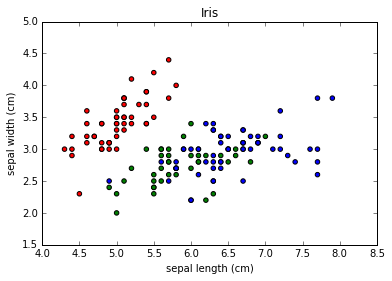

In [4]:
from sklearn import datasets 
iris = datasets.load_iris() 
print len(iris.data[:,0]), len(iris.target)
p = scatter(iris.data[:,0], iris.data[:,1], c=array(['r', 'g', 'b', 'y', 's'])[iris.target])
xlabel('sepal length (cm)')
ylabel('sepal width (cm)')
title('Iris')

Error:  96.8552581119
Error:  75.2966769532
Error:  73.2381730307
Error:  71.4968369651
Error:  68.5076674911
Error:  65.0183942764
Error:  63.788962132
Error:  63.4263018419
Error:  63.1493173489
Error:  62.8570899877
Error:  62.8798232589
Error:  62.8798232589


/pio/lscratch/1/os/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


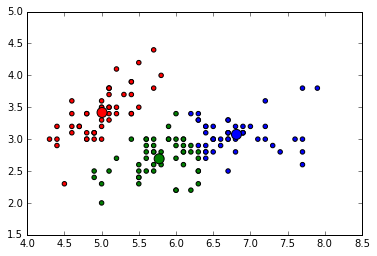

In [5]:
iris_data = iris.data[:, :2]
c, p = kmeans([iris_data], 3, 0, False)
showPlot(iris_data, c, p)

A
spd [(0, 994), (1, 998), (2, 962), (3, 1035), (4, 1011)]
Error:  11783.3465884
Error:  8160.81985574
Error:  8064.46808292
Error:  8040.57348197
Error:  8020.35668665
Error:  8007.80302468
Error:  7992.03033493
Error:  7979.59018218
Error:  7966.36980753
Error:  7958.0825751
Error:  7941.27770584
Error:  7897.05827465
Error:  7792.9419608
Error:  7561.16238225
Error:  7123.53916039
Error:  6612.04935149
Error:  6345.54061591
Error:  6278.53557031
Error:  6269.64480038
Error:  6268.34273427
Error:  6268.2358005
Error:  6268.2358005


/pio/lscratch/1/os/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


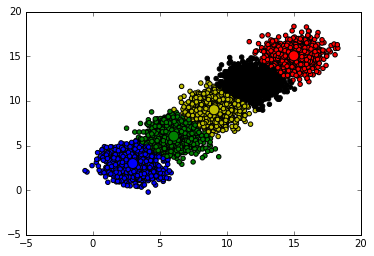

B
spd [(0, 955), (1, 1032), (2, 1026), (3, 957), (4, 1030)]
Error:  11730.9703943
Error:  8516.62819029
Error:  7260.45489461
Error:  6781.07465075
Error:  6657.99416439
Error:  6630.94694087
Error:  6623.14176233
Error:  6621.67584023
Error:  6620.8512892
Error:  6620.08846801
Error:  6619.76049199
Error:  6619.69249325
Error:  6619.69127479


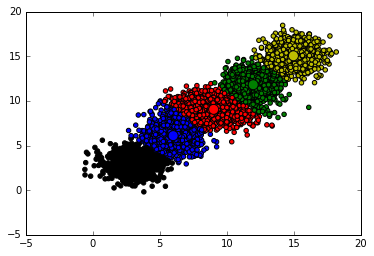

C
spd [(0, 1002), (1, 1011), (2, 1014), (3, 991), (4, 982)]
Error:  12096.6207138
Error:  8107.76425064
Error:  6963.57359085
Error:  6866.08495324
Error:  6863.67371847
Error:  6863.1750856
Error:  6863.01961885
Error:  6862.9402163
Error:  6862.9402163


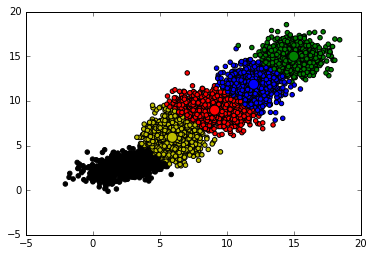

D
spd [(0, 217), (1, 91), (2, 301), (3, 102), (4, 284)]
Error:  3995.70425241
Error:  1885.4582446
Error:  1595.77551013
Error:  1570.7366911
Error:  1550.40334551
Error:  1533.90214013
Error:  1518.95096134
Error:  1500.51346262
Error:  1491.03050555
Error:  1478.4061517
Error:  1464.88937504
Error:  1448.74581301
Error:  1437.3507627
Error:  1430.97144231
Error:  1425.66599035
Error:  1421.19402528
Error:  1418.4141026
Error:  1416.70451744
Error:  1415.13346326
Error:  1414.09574455
Error:  1414.04915377
Error:  1413.87665575
Error:  1413.74952221
Error:  1413.84138894
Error:  1413.84138894


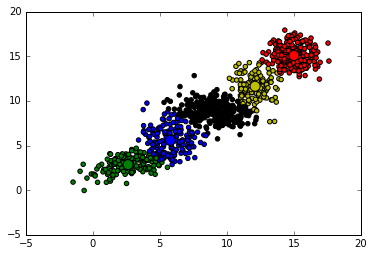

E
spd [(0, 989), (1, 1045), (2, 991), (3, 982), (4, 993)]
Error:  14989.5355875
Error:  11916.1086268
Error:  10897.9709898
Error:  10745.0778837
Error:  10701.0777032
Error:  10660.0292603
Error:  10600.9358017
Error:  10500.2702089
Error:  10271.8087491
Error:  9796.01500404
Error:  9056.87816037
Error:  8482.35575545
Error:  8287.76388307
Error:  8256.59420243
Error:  8251.87111491
Error:  8251.36400761
Error:  8251.25602136
Error:  8251.18625864
Error:  8251.12335841
Error:  8251.19860302
Error:  8251.36425475
Error:  8251.29493484
Error:  8251.29493484


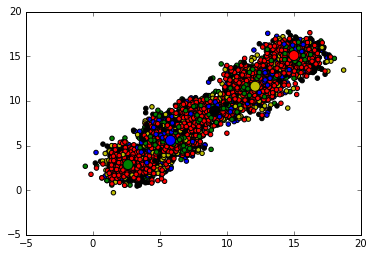

F
spd [(0, 511), (1, 476), (2, 521), (3, 479), (4, 479), (5, 497), (6, 495), (7, 499), (8, 514), (9, 529)]
Error:  97413.6647047
Error:  62080.1618516
Error:  49849.4337654
Error:  49849.4337654


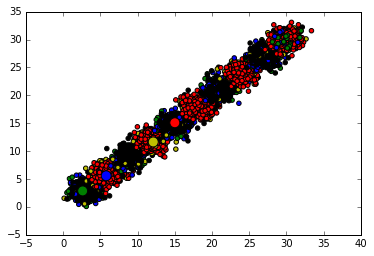

In [6]:
#1 

cov = expand_dims(identity(2),0).repeat(5, 0)
print 'A'
a = dist_data(5000, 2, 5, cov)
c, p = kmeans([a], 5, 0.01, False)
showPlot(a, c, p)

print 'B'
cov[2] = [[3,0], [0, 1]]
b = dist_data(5000, 2, 5, cov)
c, p = kmeans([b], 5, 0.01, False)
showPlot(b, c, p)

print 'C'
cov[0] = [[3,1], [1, 1]]
cd = dist_data(5000, 2, 5, cov)
c, p = kmeans([cd], 5, 0.01, False)
showPlot(cd, c, p)

print 'D'
d = dist_data(5000, 2, 5, cov, [0, 0.2, 0.3, 0.6, 0.7, 1])
c, p = kmeans([d], 5, 0.0001, False)
showPlot(d, c, p)

print 'E'
cov = expand_dims(identity(3),0).repeat(5, 0)
cov[2] = [[3,1,0],[1,1,0],[0,0,1]]
e = dist_data(5000, 3, 5, cov)
kmeans([e], 5, 0.01, False)
showPlot(e, c, p)

print 'F'
cov = expand_dims(identity(100),0).repeat(10, 0)
f = dist_data(5000, 100, 10, cov)
kmeans([f], 10, 0.01, False)
showPlot(f, c, p)

In [7]:
#2
data = dist_mixture(1000000, 1000, arange(1000), ones(1000), 100)
print data.shape

(1000,)
(1000000, 1000)


In [12]:
epoch = 1000
X = data
stream = array(split(X, cumsum(ones(X.shape[0]/epoch)*epoch)))
for x in stream:
    print x.shape

(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)

In [20]:
#2 cd

kmeans(stream, 1000, 0, False)

Done:  2000
new axis
distances
squeres
sum
transpose
ready to append
Done:  3000
new axis
distances
squeres
sum
transpose
ready to append
Done:  4000
new axis
distances
squeres
sum
transpose
ready to append
Done:  5000
new axis
distances
squeres
sum
transpose
ready to append
Done:  6000
new axis
distances
squeres
sum
transpose
ready to append
Done:  7000
new axis
distances
squeres
sum
transpose
ready to append
Done:  8000
new axis
distances
squeres
sum
transpose
ready to append
Done:  9000
new axis
distances
squeres
sum
transpose
ready to append
Done:  10000
new axis
distances
squeres
sum
transpose
ready to append
Done:  11000
new axis
distances
squeres
sum
transpose
ready to append
Done:  12000
new axis
distances
squeres
sum
transpose
ready to append
Done:  13000
new axis
distances
squeres
sum
transpose
ready to append
Done:  14000
new axis


KeyboardInterrupt: 

In [ ]:
for hist in dist_mixture(1000, 10, arange(10)*10, ones(10)).T:
    print_hist(hist)

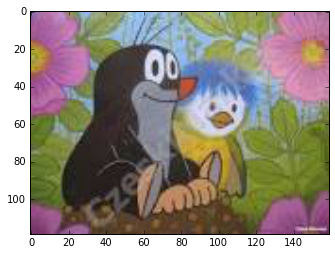

Error:  4757.43511942
Error:  3536.67094646
Error:  3406.56602712
Error:  3349.43756778
Error:  3308.35346393
Error:  3276.15980306
Error:  3254.35958285
Error:  3239.28230549
Error:  3229.09692141
Error:  3222.03764475
Error:  3217.90434061
Error:  3215.41516569
Error:  3214.23915212
Error:  3213.23341926
Error:  3212.67016428
Error:  3212.38357368
Error:  3212.04923941
Error:  3211.74128192
Error:  3211.5926537
Error:  3211.4269143
Error:  3211.31058525
Error:  3211.28697962
(119, 159, 3)


/pio/lscratch/1/os/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [14]:
image1 = imread('images.jpeg')
imshow(image1/256.)
show()
shape = image1.shape
image =  image1.reshape((-1,3))/256.
centers, partition = kmeans([image], 3, 0.1, False, idx=1000)
print shape

(119, 159, 3)


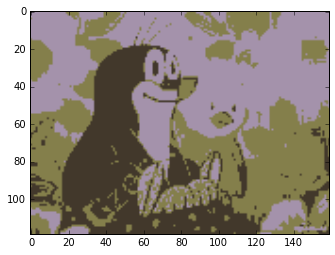

In [15]:
img = centers[partition].reshape(shape)
print img.shape
imshow(img)

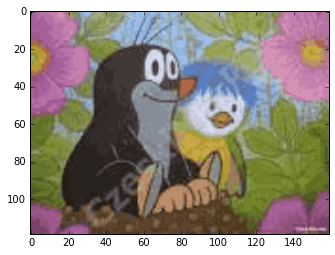

In [10]:
imshow(img.reshape(shape))